<a href="https://colab.research.google.com/github/gabriel-picussa/Prova-1-CEP---Gabriel-Picussa/blob/main/GabrielPicussa_CEP_Prova_README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP - Prova 1 - CEP**
##**Detecção de intrusão de segurança cibernética**
**Base:** cybersecurity_intrusion_data.csv  
**KPI principal (contínua):** `session_duration`  
**Amostragem:** 60 subgrupos racionais com n=5 (total 300 observações)

## Objetivo
Avaliar a **estabilidade do processo** (rede/sessões) via **Cartas de Shewhart X̄–R**, identificar causas especiais de variação e gerar os artefatos (gráficos PNG e relatório PDF).

## Checklist incluído no notebook
1. Definir KPI contínua (`session_duration`).
2. Criar 60 subgrupos racionais (n=5) preservando a ordem.
3. Calcular por subgrupo: **X̄** (média) e **R** (amplitude).
4. Calcular **X̄̄** e **R̄** e então os **limites de controle**:
   - X̄: UCL = X̄̄ + A2·R̄ ; CL = X̄̄ ; LCL = X̄̄ − A2·R̄
   - R:  UCL = D4·R̄ ; CL = R̄ ; LCL = D3·R̄ (para n=5, D3=0)
5. Plotar as cartas X̄ e R.
6. Listar pontos **fora de controle** e interpretar.
7. Salvar PNGs e gerar PDF com as figuras e resumo.


# **0) Instalar e configurar Kaggle usando URL direta do dataset**

**O que faz**: instala o cliente kaggle, grava kaggle.json com as credenciais (só para a sessão), cria a pasta de dados (/content/data_kaggle), interpreta a URL do Kaggle e baixa o dataset com kaggle datasets download, descompactando todos os .zip.

**Por quê:** padroniza o ambiente e automatiza o download para que o restante do pipeline encontre os arquivos localmente, sem cliques manuais.

In [25]:
import os, json, zipfile, glob, pathlib

# Instalar o cliente Kaggle
!pip -q install kaggle

# Credenciais Kaggle (somente nesta sessão do Colab)
kaggle_dir = pathlib.Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)
creds = {
    "username": "gabrielpicussa",
    "key": "0dcc5e253fd6527e08053a3378ba8317"
}
with open(kaggle_dir / "kaggle.json", "w") as f:
    json.dump(creds, f)
os.chmod(kaggle_dir / "kaggle.json", 0o600)

# Pasta de dados
DATA_DIR = "/content/data_kaggle"
os.makedirs(DATA_DIR, exist_ok=True)

# URL DIRETA informada por você
KAGGLE_URL = "https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset"

# Baixar interpretando a URL
dataset_slug = KAGGLE_URL.split("/")[-1]
!kaggle datasets download -d dnkumars/$dataset_slug -p $DATA_DIR --force

# Descompactar os .zip baixados
for z in glob.glob(f"{DATA_DIR}/*.zip"):
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)

print(f"✅ Dataset baixado e descompactado em: {DATA_DIR}")


Dataset URL: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset
License(s): MIT
  0% 0.00/261k [00:00<?, ?B/s]
100% 261k/261k [00:00<00:00, 451MB/s]
✅ Dataset baixado e descompactado em: /content/data_kaggle


# **1) Imports, parâmetros e localização do CSV**

**O que faz**: importa pandas/numpy/matplotlib, ajusta display/figuras, define parâmetros de CEP: KPI_NAME='session_duration', M=60 subgrupos, N=5 por subgrupo, e as constantes A2=0.577, D3=0.0, D4=2.114 (válidas para n=5). Cria OUT_DIR. Varre recursivamente DATA_DIR atrás de CSV e escolhe o mais provável (nome contendo “intrusion”/“cyber”).

**Por quê**: fixa o cenário do CEP X̄–R e garante descoberta robusta do arquivo, mesmo se o dataset vier em múltiplas pastas.

In [26]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os, glob

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.dpi"] = 120

# Parâmetros CEP
KPI_NAME = "session_duration"   # variável contínua principal
M = 60                          # <-- você pediu 60 amostras
N = 5                           # tamanho do subgrupo (permanece 5)
A2 = 0.577                      # constantes para n=5
D3 = 0.0
D4 = 2.114

OUT_DIR = "/content/cep_output"
os.makedirs(OUT_DIR, exist_ok=True)

# Localizar CSV automaticamente
csv_candidates = sorted(glob.glob(f"{DATA_DIR}/**/*.csv", recursive=True))
pref = [p for p in csv_candidates if ("intrusion" in os.path.basename(p).lower() or
                                      "cyber" in os.path.basename(p).lower())]
CSV_PATH = pref[0] if pref else (csv_candidates[0] if csv_candidates else "")

if not CSV_PATH:
    raise FileNotFoundError("Nenhum CSV foi encontrado após baixar/descompactar o dataset do Kaggle.")

print("✅ CSV selecionado:", CSV_PATH)


✅ CSV selecionado: /content/data_kaggle/cybersecurity_intrusion_data.csv


# **2) Carregar dados e preparar KPI (garante 60×5 = 300 observações)**

**O que faz**: lê o CSV, verifica se a coluna session_duration existe, força numérico, tenta ordenar por uma coluna temporal (se houver) para preservar sequência, remove NaN, e garante pelo menos 300 observações (M×N). Seleciona as primeiras 300 preservando a ordem.

**Por quê:** CEP requer dados em sequência temporal/operacional e tamanho de amostra coerente com o plano de subagrupamento.

In [27]:
df_raw = pd.read_csv(CSV_PATH)

if KPI_NAME not in df_raw.columns:
    raise ValueError(
        f"A coluna '{KPI_NAME}' não foi encontrada no CSV.\n"
        f"Algumas colunas disponíveis: {list(df_raw.columns)[:20]}"
    )

df = df_raw.copy()
df[KPI_NAME] = pd.to_numeric(df[KPI_NAME], errors="coerce")

# Ordenar por tempo se existir coluna temporal plausível
time_cols = [c for c in df.columns if any(k in c.lower() for k in ["time", "date", "timestamp"])]
if time_cols:
    sort_col = time_cols[0]
    try:
        df[sort_col] = pd.to_datetime(df[sort_col], errors="coerce")
        df = df.sort_values(by=sort_col, kind="mergesort").reset_index(drop=True)
    except Exception:
        df = df.reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Manter somente a KPI e remover NaN
df_kpi = df[[KPI_NAME]].dropna().reset_index(drop=True)

needed = M * N  # 60*5 = 300
if len(df_kpi) < needed:
    raise ValueError(
        f"Para M={M} e N={N}, são necessárias {needed} observações não nulas em '{KPI_NAME}'. "
        f"Foram encontradas {len(df_kpi)}. "
        f"Sugestões: aumentar M (p/ menor) ou escolher outra KPI com mais dados."
    )

# Selecionar as primeiras 300 observações preservando a ordem
df_kpi = df_kpi.iloc[:needed].copy().reset_index(drop=True)
print(f"✅ Dados prontos: {len(df_kpi)} observações ({M} subgrupos × {N}).")
df_kpi.head()


✅ Dados prontos: 300 observações (60 subgrupos × 5).


,session_duration
0,492.983263
1,1557.996461
2,75.044262
3,601.248835
4,532.540888


# **3) Subgrupos, X̄, R e limites de controle**

**O que faz**: etiqueta as linhas com sample=1..M (cada amostra tem N linhas), calcula X̄ᵢ (média do subgrupo) e Rᵢ (máx–mín). Em seguida:

X̄̄ = média de X̄ᵢ (média das médias)

R̄ = média de Rᵢ (média das amplitudes)

Limites X̄: UCLₓ = X̄̄ + A2·R̄, CLₓ = X̄̄, LCLₓ = X̄̄ − A2·R̄

Limites R: UCLᵣ = D4·R̄, CLᵣ = R̄, LCLᵣ = D3·R̄

**Por quê:** são as fórmulas clássicas de CEP para cartas X̄–R com subgrupos de tamanho N=5.

In [28]:
# Atribuir rótulo de amostra 1..M, cada uma com N linhas
df_kpi["sample"] = np.repeat(np.arange(1, M+1), N)

grouped = df_kpi.groupby("sample")[KPI_NAME]
xbar = grouped.mean()
r_i = grouped.max() - grouped.min()

# Estatísticas globais
Xbarbar = xbar.mean()
Rbar = r_i.mean()

# Limites de controle
UCL_x = Xbarbar + A2 * Rbar
LCL_x = Xbarbar - A2 * Rbar
CL_x  = Xbarbar

UCL_r = D4 * Rbar
LCL_r = D3 * Rbar
CL_r  = Rbar

summary_limits = pd.DataFrame({
    "Carta": ["X̄", "R"],
    "LCL":   [LCL_x, LCL_r],
    "CL":    [CL_x,  CL_r],
    "UCL":   [UCL_x, UCL_r],
    "X̄̄/R̄": [Xbarbar, Rbar]
})
print("Resumo dos limites:")
display(summary_limits)


Resumo dos limites:


,Carta,LCL,CL,UCL,X̄̄/R̄
0,X̄,-93.789191,862.176205,1818.141601,862.176205
1,R,0.000000,1656.785781,3502.445142,1656.785781


# **4) Funções de plot com eixo ajustado e marcação de 5 em 5**

**O que faz:** define plot_xbar_ooc e plot_r_ooc, que:

Traçam a série por amostra com marcadores;

Desenham UCL/CL/LCL (CL em linha contínua, UCL/LCL tracejadas);

Sinalizam OOC (fora de controle) em vermelho (X̄ᵢ ou Rᵢ além dos limites);

Ajustam eixo X para começar em 0 e ir até M+1, com ticks de 5 em 5;

Salvam a figura em PNG (opcional) e exibem.

**Por quê:** padroniza estética, destaca OOC e produz arquivos reutilizáveis (PDF/report).

In [29]:
def plot_xbar_ooc(xbar_series, CL, UCL, LCL, kpi_name, savepath=None):
    idx = xbar_series.index.values
    vals = xbar_series.values
    ooc_mask = (xbar_series > UCL) | (xbar_series < LCL)

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(idx, vals, marker="o", linewidth=1, label="X̄ (por amostra)")
    ax.scatter(idx[ooc_mask], vals[ooc_mask], s=60, c="red", zorder=3, label="Fora de controle")

    # Linhas horizontais
    ax.axhline(UCL, linestyle="--", color="black", label=f"UCL = {UCL:.2f}")
    ax.axhline(CL,  linestyle="-",  color="tab:green", label=f"CL = {CL:.2f}")
    ax.axhline(LCL, linestyle="--", color="black", label=f"LCL = {LCL:.2f}")

    # Eixo X começa em 0 e vai até M+1
    ax.set_xlim(0, len(idx) + 1)
    ax.set_xticks(np.arange(0, len(idx) + 1, 5))  # marcação de 5 em 5

    ax.set_title(f"Carta X̄ — {kpi_name} (n={N}, m={M})", fontsize=12)
    ax.set_xlabel(f"Amostra (0..{M})", fontsize=10)
    ax.set_ylabel("Média por subgrupo", fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.6)
    ax.legend(loc="best", fontsize=9, ncol=2)
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=150)
    plt.show()
    return savepath


def plot_r_ooc(r_series, CL, UCL, LCL, kpi_name, savepath=None):
    idx = r_series.index.values
    vals = r_series.values
    ooc_mask = (r_series > UCL) | (r_series < LCL)

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(idx, vals, marker="o", linewidth=1, label="R (por amostra)")
    ax.scatter(idx[ooc_mask], vals[ooc_mask], s=60, c="red", zorder=3, label="Fora de controle")

    # Linhas horizontais
    ax.axhline(UCL, linestyle="--", color="black", label=f"UCL = {UCL:.2f}")
    ax.axhline(CL,  linestyle="-",  color="tab:green", label=f"CL = {CL:.2f}")
    ax.axhline(LCL, linestyle="--", color="black", label=f"LCL = {LCL:.2f}")

    # Eixo ajustado e espaçamento 5 em 5
    ax.set_xlim(0, len(idx) + 1)
    ax.set_xticks(np.arange(0, len(idx) + 1, 5))

    ax.set_title(f"Carta R — {kpi_name} (n={N}, m={M})", fontsize=12)
    ax.set_xlabel(f"Amostra (0..{M})", fontsize=10)
    ax.set_ylabel("Amplitude por subgrupo (max-min)", fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.6)
    ax.legend(loc="best", fontsize=9, ncol=2)
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=150)
    plt.show()
    return savepath


# **5) Gerar e EXIBIR as cartas + salvar PNG**

**O que faz**: monta os caminhos de saída, chama as funções de plot para X̄ e R, grava em OUT_DIR e imprime os caminhos.

**Por quê:** materializa os gráficos para análise e para compor o relatório.

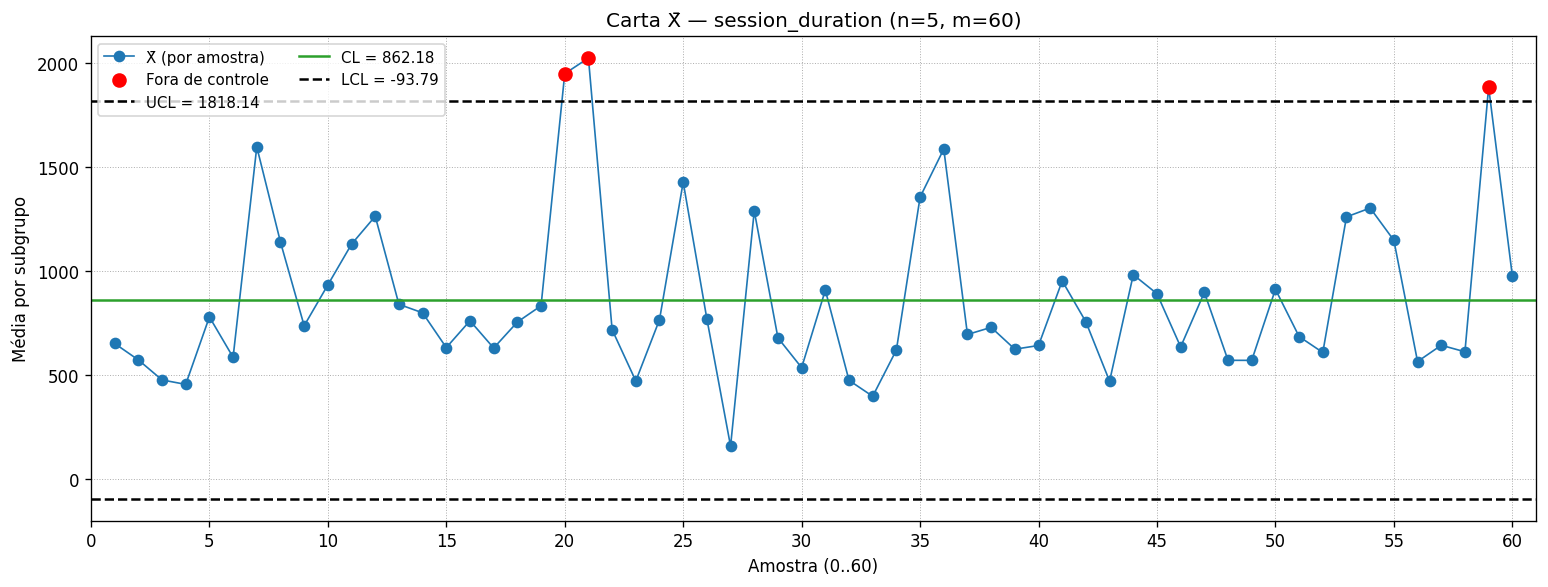

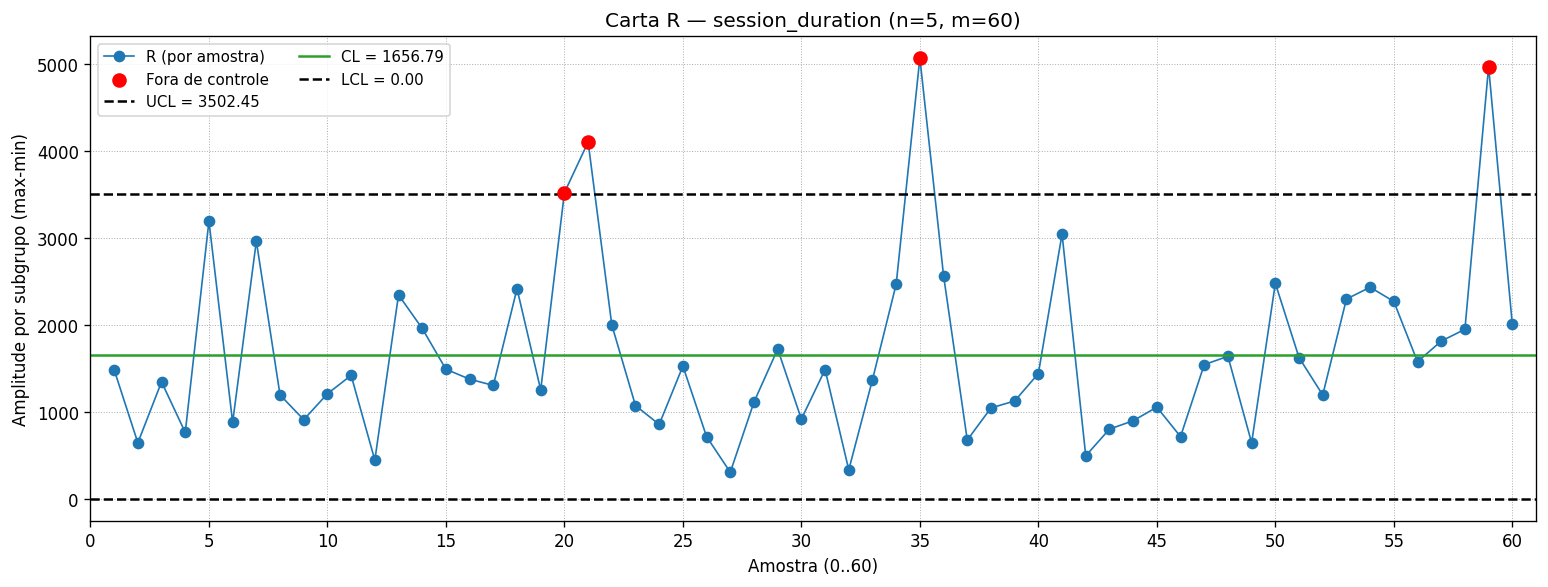

Arquivos PNG salvos em:
- /content/cep_output/xbar_session_duration_m60_n5.png
- /content/cep_output/r_session_duration_m60_n5.png


In [30]:
xbar_png = os.path.join(OUT_DIR, f"xbar_{KPI_NAME}_m{M}_n{N}.png")
r_png = os.path.join(OUT_DIR, f"r_{KPI_NAME}_m{M}_n{N}.png")

plot_xbar_ooc(xbar, CL_x, UCL_x, LCL_x, KPI_NAME, savepath=xbar_png)
plot_r_ooc(r_i, CL_r, UCL_r, LCL_r, KPI_NAME, savepath=r_png)

print("Arquivos PNG salvos em:")
print("-", xbar_png)
print("-", r_png)


# **6) Detectar pontos fora de controle + diagnóstico**

**O que faz**: cria máscaras OOC:

xbar_ooc = {X̄ᵢ | X̄ᵢ>UCLₓ ou X̄ᵢ<LCLₓ}

r_ooc = {Rᵢ | Rᵢ>UCLᵣ ou Rᵢ<LCLᵣ}
Exibe tabelas (quando houver) com amostra e valor e monta um diagnóstico textual:

se nada OOC: “Processo sob controle (regra 3-sigma)”;

OOC em X̄: suspeita de mudança de nível/média entre subgrupos;

OOC em R: suspeita de mudança de variabilidade intra-subgrupo.

**Por que**: traduz automaticamente o achado gráfico em sinais práticos de investigação.

In [31]:
xbar_ooc = xbar[(xbar > UCL_x) | (xbar < LCL_x)]
r_ooc = r_i[(r_i > UCL_r) | (r_i < LCL_r)]

print("==== PONTOS FORA DE CONTROLE — CARTA X̄ ====")
if xbar_ooc.empty:
    print("Nenhum ponto fora de controle na X̄.")
else:
    display(pd.DataFrame({"Amostra": xbar_ooc.index, "X̄": xbar_ooc.values}).reset_index(drop=True))

print("\n==== PONTOS FORA DE CONTROLE — CARTA R ====")
if r_ooc.empty:
    print("Nenhum ponto fora de controle na R.")
else:
    display(pd.DataFrame({"Amostra": r_ooc.index, "R": r_ooc.values}).reset_index(drop=True))

diagnostico = []
if xbar_ooc.empty and r_ooc.empty:
    diagnostico.append("Processo sob controle estatístico (regra 3-sigma).")
if not xbar_ooc.empty:
    diagnostico.append("Alteração de média entre subgrupos (X̄). Investigar causas especiais.")
if not r_ooc.empty:
    diagnostico.append("Alteração da variabilidade intra-subgrupo (R). Verificar mistura de condições.")

print("\n==== DIAGNÓSTICO INICIAL ====")
for item in diagnostico:
    print("-", item)


==== PONTOS FORA DE CONTROLE — CARTA X̄ ====


,Amostra,X̄
0,20,1948.944347
1,21,2024.172715
2,59,1883.818108



==== PONTOS FORA DE CONTROLE — CARTA R ====


,Amostra,R
0,20,3520.783630
1,21,4103.769827
2,35,5070.472963
3,59,4969.990991



==== DIAGNÓSTICO INICIAL ====
- Alteração de média entre subgrupos (X̄). Investigar causas especiais.
- Alteração da variabilidade intra-subgrupo (R). Verificar mistura de condições.


# **7) Gerar PDF e baixar imagens PNG em alta resolução**
**O que faz:** regrava as figuras em 300 dpi, cria um PDF com:

Página da Carta X̄ (imagem);

Página da Carta R (imagem);

Página de Resumo textual (KPI, M×N, limites formatados, pontos OOC e diagnóstico).
Depois aciona files.download para baixar os PNGs.

**Por quê:** entrega um relatório portátil para anexar/compartilhar e os PNGs em alta para apresentações.

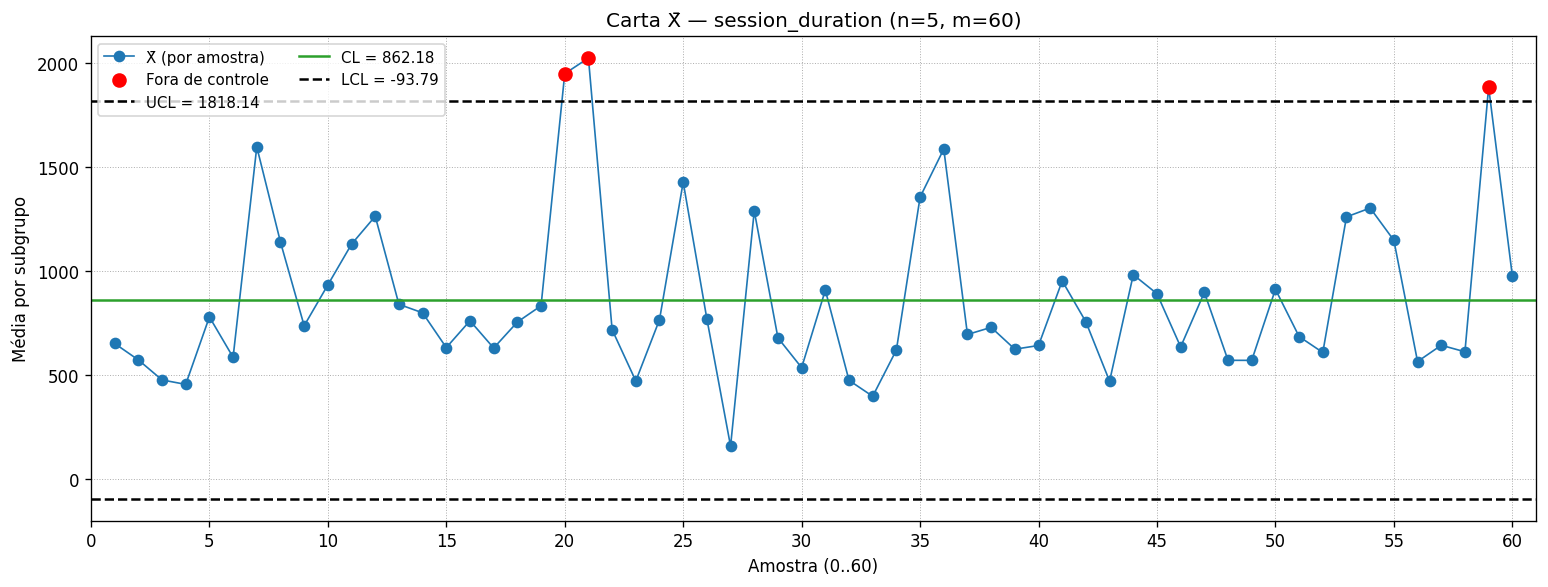

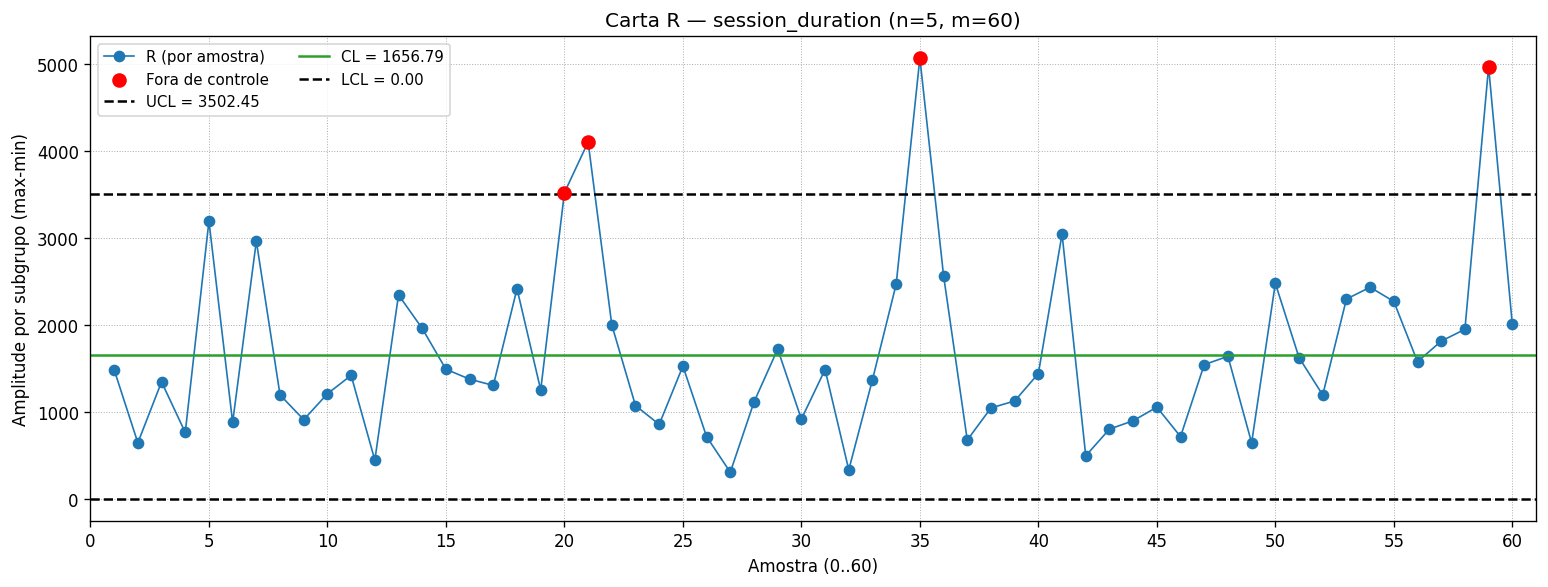

📄 PDF gerado em: /content/cep_output/CEP_report_session_duration_m60_n5_20251020_012819.pdf
🖼️ Imagens em alta resolução salvas:
- /content/cep_output/xbar_session_duration_m60_n5.png
- /content/cep_output/r_session_duration_m60_n5.png
Resumo dos limites de CONTROLE (Cartas X̄ e R):


,Carta,LCL,CL,UCL,X̄̄/R̄
0,X̄,-93.789191,862.176205,1818.141601,862.176205
1,R,0.000000,1656.785781,3502.445142,1656.785781



Limites de controle — Carta X̄
LIC (LCL_x) = -93.79
LC  (CL_x)  = 862.18
LSC (UCL_x) = 1818.14

Limites de controle — Carta R
LIC (LCL_r) = 0.00
LC  (CL_r)  = 1656.79
LSC (UCL_r) = 3502.45

⬇️ Iniciando download dos arquivos PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloads concluídos!


In [32]:
from google.colab import files

# Caminhos dos arquivos PNG existentes
xbar_png = os.path.join(OUT_DIR, f"xbar_{KPI_NAME}_m{M}_n{N}.png")
r_png    = os.path.join(OUT_DIR, f"r_{KPI_NAME}_m{M}_n{N}.png")

# Regravar as figuras em ALTA RESOLUÇÃO (300 dpi)
plot_xbar_ooc(xbar, CL_x, UCL_x, LCL_x, KPI_NAME, savepath=xbar_png)
plot_r_ooc(r_i, CL_r, UCL_r, LCL_r, KPI_NAME, savepath=r_png)

# Caminho do PDF
pdf_path = os.path.join(
    OUT_DIR,
    f"CEP_report_{KPI_NAME}_m{M}_n{N}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"
)

# === Geração do PDF (como antes) ===
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

with PdfPages(pdf_path) as pdf:
    # Página 1 — Carta X̄
    fig1 = plt.figure(figsize=(11, 8.5))
    img = plt.imread(xbar_png)
    plt.imshow(img); plt.axis('off'); plt.title("Carta X̄")
    pdf.savefig(fig1); plt.close(fig1)

    # Página 2 — Carta R
    fig2 = plt.figure(figsize=(11, 8.5))
    img2 = plt.imread(r_png)
    plt.imshow(img2); plt.axis('off'); plt.title("Carta R")
    pdf.savefig(fig2); plt.close(fig2)

    # Página 3 — Resumo textual
    fig3 = plt.figure(figsize=(11, 8.5))
    plt.axis("off")
    lines = []
    lines.append("Relatório — CEP (Cartas X̄–R)")
    lines.append(f"KPI: {KPI_NAME}")
    lines.append(f"Subgrupos: {M} × {N}  (total {M*N} observações)")
    lines.append("")
    lines.append("Resumo dos Limites:")
    for _, row in summary_limits.iterrows():
        lines.append(f"- {row['Carta']}: LCL={row['LCL']:.6g}, CL={row['CL']:.6g}, UCL={row['UCL']:.6g}")
    lines.append("")
    lines.append("Pontos fora de controle — X̄:")
    if xbar_ooc.empty:
        lines.append("- Nenhum")
    else:
        for idx, val in xbar_ooc.items():
            lines.append(f"- Amostra {int(idx)}: X̄={val:.6g}")
    lines.append("")
    lines.append("Pontos fora de controle — R:")
    if r_ooc.empty:
        lines.append("- Nenhum")
    else:
        for idx, val in r_ooc.items():
            lines.append(f"- Amostra {int(idx)}: R={val:.6g}")
    lines.append("")
    lines.append("Diagnóstico inicial:")
    if diagnostico:
        for d in diagnostico:
            lines.append(f"- {d}")
    else:
        lines.append("- (sem observações)")

    plt.text(0.01, 0.99, "\n".join(lines), va="top", fontsize=10, family="monospace")
    pdf.savefig(fig3); plt.close(fig3)

print(f"📄 PDF gerado em: {pdf_path}")
print("🖼️ Imagens em alta resolução salvas:")
print("-", xbar_png)
print("-", r_png)
print("Resumo dos limites de CONTROLE (Cartas X̄ e R):")
display(summary_limits)

# --- Exibir valores em texto, com a MESMA formatação dos gráficos (2 casas) ---
print("\nLimites de controle — Carta X̄")
print(f"LIC (LCL_x) = {LCL_x:.2f}")
print(f"LC  (CL_x)  = {CL_x:.2f}")
print(f"LSC (UCL_x) = {UCL_x:.2f}")

print("\nLimites de controle — Carta R")
print(f"LIC (LCL_r) = {LCL_r:.2f}")
print(f"LC  (CL_r)  = {CL_r:.2f}")
print(f"LSC (UCL_r) = {UCL_r:.2f}")


# === DOWNLOAD AUTOMÁTICO DAS IMAGENS ===
print("\n⬇️ Iniciando download dos arquivos PNG...")
files.download(xbar_png)
files.download(r_png)
print("✅ Downloads concluídos!")


# **8) Análise de Pontos Fora de Controle (X̄ e R)**

Neste passo, o código identificou três amostras fora de controle na carta X̄ (20, 21 e 59) e quatro amostras na carta R (20, 21, 35 e 59), todas acima do limite superior (UCL). Esses resultados mostram que houve variações significativas tanto na média quanto na amplitude de algumas amostras, indicando possíveis causas especiais atuando no processo. A identificação dessas amostras é fundamental para direcionar a investigação das anomalias e entender se elas são pontuais ou sistemáticas.

O resumo mostra que 5% das amostras da carta X̄ e 6,6% da carta R ultrapassaram os limites de controle, sugerindo instabilidade estatística. Os arquivos gerados em formato CSV registram essas ocorrências, permitindo análise posterior ou inserção em relatórios. Dessa forma, o Passo 8 marca o início da etapa de diagnóstico, transformando os cálculos de controle em informações objetivas sobre o comportamento do processo.

In [33]:

import pandas as pd
import numpy as np
import os

# (Re)usa séries e limites calculados antes:
# xbar, r_i, UCL_x, LCL_x, CL_x, UCL_r, LCL_r, CL_r, OUT_DIR

def _rotulo_direcao(val, LCL, UCL):
    if val > UCL: return "Acima do UCL"
    if val < LCL: return "Abaixo do LCL"
    return "Dentro"

# Máscaras OOC
mask_x_ooc = (xbar > UCL_x) | (xbar < LCL_x)
mask_r_ooc = (r_i  > UCL_r) | (r_i  < LCL_r)

# Tabelas detalhadas
tbl_x_ooc = pd.DataFrame({
    "Amostra": xbar.index[mask_x_ooc].astype(int),
    "X̄":      xbar[mask_x_ooc].values,
    "Direção": [ _rotulo_direcao(v, LCL_x, UCL_x) for v in xbar[mask_x_ooc].values ]
}).reset_index(drop=True)

tbl_r_ooc = pd.DataFrame({
    "Amostra": r_i.index[mask_r_ooc].astype(int),
    "R":      r_i[mask_r_ooc].values,
    "Direção": [ _rotulo_direcao(v, LCL_r, UCL_r) for v in r_i[mask_r_ooc].values ]
}).reset_index(drop=True)

# Resumo quantitativo
total_samples = len(xbar)
resumo = pd.DataFrame({
    "Carta": ["X̄","R"],
    "Qtd OOC": [len(tbl_x_ooc), len(tbl_r_ooc)],
    "% OOC":   [100*len(tbl_x_ooc)/total_samples, 100*len(tbl_r_ooc)/total_samples]
})

print("==== PONTOS FORA DE CONTROLE — CARTA X̄ ====")
display(tbl_x_ooc if not tbl_x_ooc.empty else pd.DataFrame(columns=["Amostra","X̄","Direção"]))
print("\n==== PONTOS FORA DE CONTROLE — CARTA R ====")
display(tbl_r_ooc if not tbl_r_ooc.empty else pd.DataFrame(columns=["Amostra","R","Direção"]))
print("\n==== RESUMO ====")
display(resumo)

# Salva para o relatório
ooc_x_csv = os.path.join(OUT_DIR, "ooc_xbar.csv")
ooc_r_csv = os.path.join(OUT_DIR, "ooc_r.csv")
resumo_csv = os.path.join(OUT_DIR, "ooc_resumo.csv")
tbl_x_ooc.to_csv(ooc_x_csv, index=False)
tbl_r_ooc.to_csv(ooc_r_csv, index=False)
resumo.to_csv(resumo_csv, index=False)

print(f"\nArquivos salvos:\n- {ooc_x_csv}\n- {ooc_r_csv}\n- {resumo_csv}")


==== PONTOS FORA DE CONTROLE — CARTA X̄ ====


,Amostra,X̄,Direção
0,20,1948.944347,Acima do UCL
1,21,2024.172715,Acima do UCL
2,59,1883.818108,Acima do UCL



==== PONTOS FORA DE CONTROLE — CARTA R ====


,Amostra,R,Direção
0,20,3520.783630,Acima do UCL
1,21,4103.769827,Acima do UCL
2,35,5070.472963,Acima do UCL
3,59,4969.990991,Acima do UCL



==== RESUMO ====


,Carta,Qtd OOC,% OOC
0,X̄,3,5.000000
1,R,4,6.666667



Arquivos salvos:
- /content/cep_output/ooc_xbar.csv
- /content/cep_output/ooc_r.csv
- /content/cep_output/ooc_resumo.csv


# **9) Interpretação dos Resultados**

Com base nos resultados do Passo 8, o Passo 9 apresentou um diagnóstico que confirma a presença de causas especiais de variação. O relatório gerado automaticamente listou as mesmas amostras fora dos limites, reforçando que as amostras 20, 21 e 59 apresentaram desvios na média, enquanto as amostras 20, 21, 35 e 59 mostraram dispersões elevadas dentro dos subgrupos. Esse padrão indica que há instabilidades tanto no nível do processo quanto na consistência das medições.

As ações recomendadas incluem revisar ajustes recentes de máquina, verificar calibração de instrumentos e checar possíveis alterações de matéria-prima ou de turno. Também é indicado investigar fontes de variabilidade intra-subgrupo, especialmente nas amostras com R fora de controle. O objetivo é identificar e eliminar as causas especiais, para que o processo retorne a um estado de controle estável e previsível.

In [34]:

# OPCIONAL: defina especificações, se aplicável à sua KPI.
# Se não houver especificações formais, deixe como None.
LIE = None   # ex.: 490.0
LSE = None   # ex.: 510.0

def interpretar_processo(xbar, r_i, LCL_x, UCL_x, LCL_r, UCL_r, LIE=None, LSE=None):
    # OOC
    x_ooc_idx = xbar[(xbar > UCL_x) | (xbar < LCL_x)]
    r_ooc_idx = r_i[(r_i > UCL_r) | (r_i < LCL_r)]
    sob_controle = x_ooc_idx.empty and r_ooc_idx.empty

    linhas = []
    linhas.append("DIAGNÓSTICO DO CEP (X̄–R)")
    linhas.append("-" * 40)
    if sob_controle:
        linhas.append("• Processo sob controle estatístico (regra 3-sigma).")
    else:
        linhas.append("• Evidências de causas especiais de variação:")
        if not x_ooc_idx.empty:
            linhas.append("  - Carta X̄: " + ", ".join([f"Amostra {int(i)} (X̄={v:.4g})" for i,v in x_ooc_idx.items()]))
        if not r_ooc_idx.empty:
            linhas.append("  - Carta R: " + ", ".join([f"Amostra {int(i)} (R={v:.4g})" for i,v in r_ooc_idx.items()]))

    # Relação com especificações (se disponíveis)
    if (LIE is not None) and (LSE is not None):
        # Aproximação simples: compara médias de subgrupo (X̄) aos limites de especificação
        prop_xbar_fora_espec = np.mean((xbar < LIE) | (xbar > LSE))
        linhas.append("-" * 40)
        linhas.append("LIMITES DE ESPECIFICAÇÃO (opcional)")
        linhas.append(f"• LIE={LIE}, LSE={LSE}")
        linhas.append(f"• Proporção de médias de subgrupo fora de especificação: {100*prop_xbar_fora_espec:.2f}%")
        linhas.append("• Observação: limites de controle medem estabilidade; limites de especificação medem conformidade.")

    # Ações corretivas sugeridas (genéricas)
    linhas.append("-" * 40)
    linhas.append("AÇÕES RECOMENDADAS")
    if sob_controle:
        linhas.append("• Manter condições atuais e monitorar rotineiramente; avaliar capabilidade (Cp/Cpk) se houver especificações.")
    else:
        linhas.append("• Investigar ajustes recentes de máquina/setup próximos às amostras sinalizadas.")
        linhas.append("• Verificar instrumento de medição e calibração.")
        linhas.append("• Revisar matéria-prima/lotes e mudanças de turno/equipe.")
        linhas.append("• Se R estiver OOC: focar em fontes de variabilidade intra-subgrupo (mistura de condições).")
        linhas.append("• Após a ação, coletar nova amostra para verificação de retorno ao controle.")

    return "\n".join(linhas)

print(interpretar_processo(xbar, r_i, LCL_x, UCL_x, LCL_r, UCL_r, LIE=LIE, LSE=LSE))


DIAGNÓSTICO DO CEP (X̄–R)
----------------------------------------
• Evidências de causas especiais de variação:
  - Carta X̄: Amostra 20 (X̄=1949), Amostra 21 (X̄=2024), Amostra 59 (X̄=1884)
  - Carta R: Amostra 20 (R=3521), Amostra 21 (R=4104), Amostra 35 (R=5070), Amostra 59 (R=4970)
----------------------------------------
AÇÕES RECOMENDADAS
• Investigar ajustes recentes de máquina/setup próximos às amostras sinalizadas.
• Verificar instrumento de medição e calibração.
• Revisar matéria-prima/lotes e mudanças de turno/equipe.
• Se R estiver OOC: focar em fontes de variabilidade intra-subgrupo (mistura de condições).
• Após a ação, coletar nova amostra para verificação de retorno ao controle.
